<h2 align="center" style="background-color:#2D3436;color:white;border-radius:8px;padding:15px">Forecasting Stock Prices using Sentiment Analysis and Time Series Models: An Advanced Data Analytics Approach</h2>

### **Table of Contents**

- [Introduction](#Introduction)
   - Assessment Overview
   - Objectives
   - Data Source and Storage
- [Install and Import Required Libraries](#Install-and-Import-Required-Libraries)
- [Load Dataset](#Load-Dataset)

<h3 style="background-color:#2D3436;color:white;border-radius:8px;padding:15px">Introduction</h3>

### Assessment Overview

### Objectives

### Data Source and Storage

<h3 style="background-color:#2D3436;color:white;border-radius:8px;padding:15px">Install and Import Required Libraries</h3>

In [1]:
!pip install -q pyspark pandas
!pip install -q -U kaleido
!pip install -q pmdarima

In [55]:
import re
import os
from datetime import datetime, timedelta

import sqlite3
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, when, lit, to_date, avg, stddev, desc, first, round
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, LongType
from pyspark.sql.window import Window

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping

import statsmodels.api as sm
from pmdarima import auto_arima

import warnings
warnings.filterwarnings('ignore') # Ignore warnings

In [3]:
# CONFIGURATIONS
pd.options.display.float_format = '{:.3f}'.format # Pandas numeric outputs are displayed with 3 decimal places

<h3 style="background-color:#2D3436;color:white;border-radius:8px;padding:15px">Load Dataset</h3>

#### **Initialize Spark Session and Define Data Paths**

In [4]:
spark = SparkSession.builder \
    .appName("Stock Tweet Analysis") \
    .config("spark.memory.offHeap.enabled", "true") \
    .config("spark.memory.offHeap.size", "10g") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/24 17:27:15 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
spark.sparkContext.setLogLevel("ERROR")

In [6]:
tweet_data_path = "/kaggle/input/stock-tweet-and-price/stock-tweet-and-price/stocktweet/stocktweet.csv"
stock_price_folder = "/kaggle/input/stock-tweet-and-price/stock-tweet-and-price/stockprice"
db_path = "stock_analysis.db"

#### **Define Data Schemas**

In [7]:
# Define the companies to analyze
companies = ['AAPL', 'AMZN', 'MSFT', 'TSLA', 'GOOGL', 'FB']

In [8]:
# Define schema for tweet data
tweet_schema = StructType([
    StructField("id", StringType(), True),
    StructField("date", StringType(), True),
    StructField("ticker", StringType(), True),
    StructField("tweet", StringType(), True)
])

In [9]:
# Define schema for stock price data
stock_schema = StructType([
    StructField("Date", StringType(), True),
    StructField("Open", DoubleType(), True),
    StructField("High", DoubleType(), True),
    StructField("Low", DoubleType(), True),
    StructField("Close", DoubleType(), True),
    StructField("Adj Close", DoubleType(), True),
    StructField("Volume", LongType(), True)
])

#### **Define Helper Functions for Loading Data**

In [10]:
def load_tweet_data():
    df = spark.read.csv(tweet_data_path, header=True, schema=tweet_schema)
    # Convert date string to standard format
    df = df.withColumn("date", to_date(col("date"), "MM/dd/yyyy"))
    # Filter tweets for selected companies
    df = df.filter(col("ticker").isin(companies))
    return df

In [11]:
def load_stock_data(ticker):
    file_path = os.path.join(stock_price_folder, f"{ticker}.csv")
    df = spark.read.csv(file_path, header=True, schema=stock_schema)
    # Convert date string to standard format
    df = df.withColumn("Date", to_date(col("Date"), "yyyy-MM-dd"))
    # Add ticker column
    df = df.withColumn("ticker", lit(ticker))
    return df

#### **Load Datasets using Helper Functions**

In [12]:
print("Loading tweet data...")
tweets_df = load_tweet_data()
print("Tweet data loaded")

Loading tweet data...
Tweet data loaded


In [13]:
print("Loading stock price data...")
stock_dfs = {}
for company in companies:
    stock_dfs[company] = load_stock_data(company)
print("Stock price data loaded")

Loading stock price data...
Stock price data loaded


<h3 style="background-color:#2D3436;color:white;border-radius:8px;padding:15px">Data Exploration</h3>

#### **Viewing First 5 Rows of Each Stock DataFrame**

In [14]:
def show_top_rows(df, name):
    """Display the top 5 rows of a DataFrame with floats rounded to 3 decimal places"""
    print(f"\n{name} Top 5 Rows:")

    # Identify float/double columns
    float_cols = [f.name for f in df.schema.fields if f.dataType.simpleString() in ['float', 'double']]

    # Round float/double columns to 3 decimal places
    rounded_df = df
    for col_name in float_cols:
        rounded_df = rounded_df.withColumn(col_name, round(col(col_name), 3))

    rounded_df.show(5, truncate=False)

In [15]:
for ticker, df in stock_dfs.items():
    show_top_rows(df, ticker)


AAPL Top 5 Rows:
+----------+------+------+------+------+---------+---------+------+
|Date      |Open  |High  |Low   |Close |Adj Close|Volume   |ticker|
+----------+------+------+------+------+---------+---------+------+
|2019-12-31|72.482|73.42 |72.38 |73.412|71.521   |100805600|AAPL  |
|2020-01-02|74.06 |75.15 |73.798|75.088|73.153   |135480400|AAPL  |
|2020-01-03|74.287|75.145|74.125|74.357|72.441   |146322800|AAPL  |
|2020-01-06|73.448|74.99 |73.188|74.95 |73.019   |118387200|AAPL  |
|2020-01-07|74.96 |75.225|74.37 |74.598|72.675   |108872000|AAPL  |
+----------+------+------+------+------+---------+---------+------+
only showing top 5 rows


AMZN Top 5 Rows:
+----------+------+------+------+------+---------+--------+------+
|Date      |Open  |High  |Low   |Close |Adj Close|Volume  |ticker|
+----------+------+------+------+------+---------+--------+------+
|2019-12-31|92.1  |92.663|91.612|92.392|92.392   |50130000|AMZN  |
|2020-01-02|93.75 |94.9  |93.207|94.9  |94.9     |80580000|

#### **Statistical Summary of Each Stock DataFrame**

In [16]:
def show_summary(df, name):
    """Display statistical summary of a DataFrame with values rounded to 3 decimal places"""
    print(f"\n{name} Statistical Summary:")

    # Compute summary
    summary_df = df.describe()

    # Try to round numeric values only (skip the "summary" column)
    numeric_cols = [c for c in summary_df.columns if c != "summary"]
    for c in numeric_cols:
        summary_df = summary_df.withColumn(c, round(col(c).cast("double"), 3))

    summary_df.show(truncate=False)

In [17]:
for ticker, df in stock_dfs.items():
    show_summary(df, ticker)


AAPL Statistical Summary:
+-------+------+------+------+------+---------+---------------+------+
|summary|Open  |High  |Low   |Close |Adj Close|Volume         |ticker|
+-------+------+------+------+------+---------+---------------+------+
|count  |254.0 |254.0 |254.0 |254.0 |254.0    |254.0          |254.0 |
|mean   |95.178|96.57 |93.828|95.261|93.308   |1.57341185827E8|NULL  |
|stddev |22.015|22.099|21.58 |21.81 |21.574   |6.9783515227E7 |NULL  |
|min    |57.02 |57.125|53.153|56.092|54.777   |4.66913E7      |NULL  |
|max    |138.05|138.79|134.34|136.69|134.318  |4.2651E8       |NULL  |
+-------+------+------+------+------+---------+---------------+------+


AMZN Statistical Summary:
+-------+-------+-------+-------+-------+---------+--------------+------+
|summary|Open   |High   |Low    |Close  |Adj Close|Volume        |ticker|
+-------+-------+-------+-------+-------+---------+--------------+------+
|count  |254.0  |254.0  |254.0  |254.0  |254.0    |254.0         |254.0 |
|mean   |1

#### **Checking for Missing Values**

In [18]:
def check_missing_values(df, name):
    """Check missing values in a Dataframe"""
    print(f"\nMissing Values in {name}:")
    df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

In [19]:
for ticker, df in stock_dfs.items():
    check_missing_values(df, ticker)


Missing Values in AAPL:
+----+----+----+---+-----+---------+------+------+
|Date|Open|High|Low|Close|Adj Close|Volume|ticker|
+----+----+----+---+-----+---------+------+------+
|   0|   0|   0|  0|    0|        0|     0|     0|
+----+----+----+---+-----+---------+------+------+


Missing Values in AMZN:
+----+----+----+---+-----+---------+------+------+
|Date|Open|High|Low|Close|Adj Close|Volume|ticker|
+----+----+----+---+-----+---------+------+------+
|   0|   0|   0|  0|    0|        0|     0|     0|
+----+----+----+---+-----+---------+------+------+


Missing Values in MSFT:
+----+----+----+---+-----+---------+------+------+
|Date|Open|High|Low|Close|Adj Close|Volume|ticker|
+----+----+----+---+-----+---------+------+------+
|   0|   0|   0|  0|    0|        0|     0|     0|
+----+----+----+---+-----+---------+------+------+


Missing Values in TSLA:
+----+----+----+---+-----+---------+------+------+
|Date|Open|High|Low|Close|Adj Close|Volume|ticker|
+----+----+----+---+-----+----

#### **Explore tweet data**

In [20]:
show_top_rows(tweets_df, "Tweet Data")
show_summary(tweets_df, "Tweet Data")
check_missing_values(tweets_df, "Tweets")


Tweet Data Top 5 Rows:
+------+----------+------+-------------------------------------------------------------------------------------------------------------------------------------------+
|id    |date      |ticker|tweet                                                                                                                                      |
+------+----------+------+-------------------------------------------------------------------------------------------------------------------------------------------+
|100001|2020-01-01|AMZN  |$AMZN Dow futures up by 100 points already 🥳                                                                                              |
|100002|2020-01-01|TSLA  |$TSLA Daddy's drinkin' eArly tonight! Here's to a PT of ohhhhh $1000 in 2020! 🍻                                                           |
|100003|2020-01-01|AAPL  |$AAPL We’ll been riding since last December from $172.12 what to do. Decisions decisions hmm 🤔. I have 20 mins to dec

In [21]:
# Tweet counts
print("\nTweet Count by Company:")
tweets_df.groupBy("ticker").count().orderBy(desc("count")).show()

print("\nTweet Count by Date (Top 10):")
tweets_df.groupBy("date").count().orderBy(desc("count")).show(10)


Tweet Count by Company:
+------+-----+
|ticker|count|
+------+-----+
|  TSLA| 4341|
|  AAPL| 1721|
|  AMZN|  407|
|  MSFT|  271|
|    FB|  204|
| GOOGL|   17|
+------+-----+


Tweet Count by Date (Top 10):
+----------+-----+
|      date|count|
+----------+-----+
|      NULL| 4177|
|2020-03-09|  137|
|2020-01-09|  114|
|2020-01-05|  108|
|2020-02-09|  102|
|2020-04-09|  101|
|2020-08-09|   78|
|2020-09-09|   65|
|2020-10-09|   63|
|2020-03-03|   60|
+----------+-----+
only showing top 10 rows



### **Data Exploration Summary**

This analysis examines historical stock data from six major companies (AAPL, AMZN, MSFT, TSLA, GOOGL, FB) along with related Twitter activity. The stock data spans approximately 254 trading days starting from December 31, 2019, to 2020-12-31. All datasets cover the same 1-year span and include trading days only, excluding weekends.

| Company | Avg. Close (\$) | Price Range Close (\$)     | Avg. Daily Volume | Max Volume     | Volatility (StdDev) |
|:--------|:----------------|:--------------------|:------------------|:---------------|:--------------------|
| AAPL    | 95.26           | 56.09 - 136.69      | 157,341,186       | 426,510,000    | 21.81               |
| AMZN    | 133.88          | 83.83 - 176.57      | 98,428,913        | 311,346,000    | 27.36               |
| MSFT    | 192.89          | 135.42 - 231.65     | 37,583,647        | 97,012,700     | 23.06               |
| TSLA    | 96.39           | 24.08 - 235.22      | 225,641,822       | 914,082,000    | 56.39               |
| GOOGL   | 73.92           | 52.71 - 91.25       | 39,872,646        | 108,358,000    | 8.75                |
| FB      | 234.44          | 146.01 - 303.91     | 22,393,174        | 76,343,900     | 38.53               |

#### **1. Apple (AAPL) Data**
- **Date Range:** The data for Apple spans from 2019-12-31 to 2020-12-31.
- **Missing Values:** There are no missing values across any of the columns (Date, Open, High, Low, Close, Adj Close, Volume, Ticker).
- **Statistical Summary:**
  - The average closing price is **\$95.26**, with a minimum of **\$56.09** and a maximum of **\$136.69**.
  - The average daily trading volume is **157,341,186 shares**, with a peak of **426,510,000 shares**.
  - The stock shows moderate volatility with a standard deviation of **\$21.81** in closing price.

---

#### **2. Amazon (AMZN) Data**
- **Date Range:** The data for Amazon spans from 2019-12-31 to 2020-12-31.
- **Missing Values:** There are no missing values in any column.
- **Statistical Summary:**
  - The average closing price is **\$133.88**, with a low of **\$83.83** and a high of **\$176.57**.
  - Average trading volume is **98,428,913 shares**, reaching a maximum of **311,346,000 shares**.

---

#### **3. Microsoft (MSFT) Data**
- **Date Range:** The data for Microsoft spans from 2019-12-31 to 2020-12-31.
- **Missing Values:** There are no missing values in the dataset.
- **Statistical Summary:**
  - The mean closing price is **\$192.89**, with a minimum of **\$135.42** and a maximum of **\$231.65**.
  - Average daily volume is **37,583,647 shares**, with a maximum of **97,012,700 shares**.

---

#### **4. Tesla (TSLA) Data**
- **Date Range:** The data for Tesla spans from 2019-12-31 to 2020-12-31.
- **Missing Values:** There are no missing values present.
- **Statistical Summary:**
  - The average closing price is **\$96.39**, ranging from a low of **\$24.08** to a high of **\$235.22**.
  - Tesla experienced intense trading activity, with a mean volume of **225,641,822 shares** and a peak of **914,082,000 shares**.
  - The stock shows high volatility, reflective of its rapid growth and media presence in 2020.

---

#### **5. Google (GOOGL) Data**
- **Date Range:** The data for Google spans from 2019-12-31 to 2020-12-31.
- **Missing Values:** No missing values found in the data.
- **Statistical Summary:**
  - The average closing price is **\$73.92**, with prices ranging from **\$52.71** to **\$91.25**.
  - Average daily volume is **39,872,646 shares**, with a maximum of **108,358,000 shares**.

---

#### **6. Meta (Facebook - FB) Data**
- **Date Range:** The data for Facebook spans from 2019-12-31 to 2020-12-31.
- **Missing Values:** All fields are complete with no missing data.
- **Statistical Summary:**
  - The average closing price is **\$234.44**, with a minimum of **\$146.01** and a maximum of **\$303.91**.
  - Average volume is **22,393,174 shares**, peaking at **76,343,900 shares**.

### **Key Observations**

- **Price Trends:**
  - Facebook had the highest average closing price, followed by Microsoft.
  - Tesla had the lowest minimum price but showed the most aggressive growth in 2020.

- **Volume Trends:**
  - Tesla and Apple recorded the highest peak trading volumes, suggesting strong investor attention.
  - Microsoft and Amazon maintained consistent trading volumes, while Google and Facebook were more moderate.

- **Volatility:**
  - Tesla exhibited the highest price volatility, indicative of rapid price swings and speculative trading.
  - Google (GOOGL) and Apple (AAPL) had more stable price movements.

---

#### **Tweet Distribution by Company:**
1. TSLA: 4,341 tweets (62.4%)
2. AAPL: 1,721 tweets (24.7%)
3. AMZN: 407 tweets (5.8%)
4. MSFT: 271 tweets (3.9%)
5. FB: 204 tweets (2.9%)
6. GOOGL: 17 tweets (0.2%)

#### **Twitter Data Insights:**

* **Social Media Attention Disparity:** Tesla dominated over 62% of all Twitter mentions despite not being the largest company by market cap. 

* **Data Quality Concerns:** 4,177 tweets (60%) have missing date information.

* **Activity Clustering:** Remaining tweets show concentration on specific dates:
  - March 9, 2020: 137 tweets (potential market event)
  - January 9, 2020: 114 tweets
  - January 5, 2020: 108 tweets

The clustering of tweets around specific dates (March 9, 2020: 137 tweets; January 9, 2020: 114 tweets) likely corresponds to significant market events or company announcements. March 9, 2020, in particular, coincides with the beginning of major market declines related to the pandemic, suggesting intensified social media discussion during market stress.

<h3 style="background-color:#2D3436;color:white;border-radius:8px;padding:15px">Data Preprocessing</h3>

Here, I performed a light data preprocessing by

- Calculating Daily Tweet Counts: Aggregating raw tweet data to count mentions per company per day.
- Joining Stock and Tweet Data: Merging market data with social media activity metrics.
- Handling Missing Values: Ensuring consistent treatment of days without Twitter activity.

In [22]:
# Process tweet data - calculate daily tweet counts for each company
tweet_counts = tweets_df.groupBy("date", "ticker").count().withColumnRenamed("count", "tweet_count")

In [23]:
def preprocess_data(stock_dfs, tweets_df):
    """Process and join data for each company, rounding numeric columns to 3 decimal places"""
    processed_dfs = {}
    
    # Precompute tweet counts
    tweet_counts = tweets_df.groupBy("date", "ticker").count().withColumnRenamed("count", "tweet_count")

    for ticker, stock_df in stock_dfs.items():
        # Rename date column for consistent joining
        stock_df = stock_df.withColumnRenamed("Date", "date")
        
        # Join stock data with tweet counts
        joined_df = stock_df.join(
            tweet_counts.filter(col("ticker") == ticker),
            on=["date", "ticker"],
            how="left"
        )
        
        # Fill missing tweet counts with 0
        joined_df = joined_df.na.fill({"tweet_count": 0})
        
        # Round float/double columns to 3 decimal places for display
        float_cols = [f.name for f in joined_df.schema.fields if f.dataType.simpleString() in ['float', 'double']]
        for col_name in float_cols:
            joined_df = joined_df.withColumn(col_name, round(col(col_name), 3))
        
        # Store the processed DataFrame
        processed_dfs[ticker] = joined_df
        
        # Show the processed data
        print(f"\nProcessed {ticker} Data:")
        joined_df.show(5, truncate=False)
    
    return processed_dfs

In [24]:
processed_dfs = preprocess_data(stock_dfs, tweets_df)


Processed AAPL Data:
+----------+------+------+------+------+------+---------+---------+-----------+
|date      |ticker|Open  |High  |Low   |Close |Adj Close|Volume   |tweet_count|
+----------+------+------+------+------+------+---------+---------+-----------+
|2019-12-31|AAPL  |72.482|73.42 |72.38 |73.412|71.521   |100805600|0          |
|2020-01-02|AAPL  |74.06 |75.15 |73.798|75.088|73.153   |135480400|3          |
|2020-01-03|AAPL  |74.287|75.145|74.125|74.357|72.441   |146322800|1          |
|2020-01-06|AAPL  |73.448|74.99 |73.188|74.95 |73.019   |118387200|2          |
|2020-01-07|AAPL  |74.96 |75.225|74.37 |74.598|72.675   |108872000|0          |
+----------+------+------+------+------+------+---------+---------+-----------+
only showing top 5 rows


Processed AMZN Data:
+----------+------+------+------+------+------+---------+--------+-----------+
|date      |ticker|Open  |High  |Low   |Close |Adj Close|Volume  |tweet_count|
+----------+------+------+------+------+------+------

<h3 style="background-color:#2D3436;color:white;border-radius:8px;padding:15px">Store Data to SQL Database</h3>

In [25]:
# Create SQLite database connection
def create_db_connection():
    conn = sqlite3.connect(db_path)
    return conn

In [26]:
# Store data to SQLite using PySpark
def store_data_to_sql(tweets_df, stock_dfs, processed_dfs):
    # Create database connection
    conn = create_db_connection()
    
    # Store tweets data - convert to pandas first
    tweets_df.toPandas().to_sql("tweets", conn, if_exists="replace", index=False)
    
    # Store stock price data for each company
    for ticker, df in stock_dfs.items():
        df.toPandas().to_sql(f"stock_prices_{ticker}", conn, if_exists="replace", index=False)
    
    # Store processed data for each company
    for ticker, df in processed_dfs.items():
        df.toPandas().to_sql(f"processed_{ticker}", conn, if_exists="replace", index=False)
    
    conn.close()
    print("All data successfully stored in SQLite database")

In [27]:
# Store raw and processed data in SQLite
print("Storing data in SQLite...")
store_data_to_sql(tweets_df, stock_dfs, processed_dfs)

Storing data in SQLite...
All data successfully stored in SQLite database


<h3 style="background-color:#2D3436;color:white;border-radius:8px;padding:15px">Working with Pandas DataFrame</h3>

In this section, I converted the processed Spark DataFrames to pandas format for easier analysis and visualization while maintaining data integrity from the Spark processing pipeline.

In [28]:
def convert_to_pandas(processed_dfs):
    """Convert processed Spark DataFrames to pandas DataFrames"""
    pandas_dfs = {}
    for ticker, df in processed_dfs.items():
        pandas_dfs[ticker] = df.toPandas()
    return pandas_dfs

In [29]:
stock_pandas_df = convert_to_pandas(processed_dfs)
tweets_pandas_df = tweets_df.toPandas()

In [30]:
for ticker, df in stock_pandas_df.items():
    print(ticker, 'Pandas Dataframe')
    display(df.head())
    print('\n')

AAPL Pandas Dataframe


,date,ticker,Open,High,Low,Close,Adj Close,Volume,tweet_count
0,2019-12-31,AAPL,72.482,73.420,72.380,73.412,71.521,100805600,0
1,2020-01-02,AAPL,74.060,75.150,73.798,75.088,73.153,135480400,3
2,2020-01-03,AAPL,74.287,75.145,74.125,74.357,72.441,146322800,1
3,2020-01-06,AAPL,73.448,74.990,73.188,74.950,73.019,118387200,2
4,2020-01-07,AAPL,74.960,75.225,74.370,74.598,72.675,108872000,0




AMZN Pandas Dataframe


,date,ticker,Open,High,Low,Close,Adj Close,Volume,tweet_count
0,2019-12-31,AMZN,92.100,92.663,91.612,92.392,92.392,50130000,0
1,2020-01-02,AMZN,93.750,94.900,93.207,94.900,94.900,80580000,1
2,2020-01-03,AMZN,93.225,94.310,93.225,93.748,93.748,75288000,0
3,2020-01-06,AMZN,93.000,95.185,93.000,95.144,95.144,81236000,0
4,2020-01-07,AMZN,95.225,95.695,94.602,95.343,95.343,80898000,4




MSFT Pandas Dataframe


,date,ticker,Open,High,Low,Close,Adj Close,Volume,tweet_count
0,2019-12-31,MSFT,156.770,157.770,156.450,157.700,151.966,18369400,0
1,2020-01-02,MSFT,158.780,160.730,158.330,160.620,154.779,22622100,0
2,2020-01-03,MSFT,158.320,159.950,158.060,158.620,152.852,21116200,0
3,2020-01-06,MSFT,157.080,159.100,156.510,159.030,153.247,20813700,0
4,2020-01-07,MSFT,159.320,159.670,157.320,157.580,151.850,21634100,1




TSLA Pandas Dataframe


,date,ticker,Open,High,Low,Close,Adj Close,Volume,tweet_count
0,2019-12-31,TSLA,27.000,28.086,26.805,27.889,27.889,154285500,0
1,2020-01-02,TSLA,28.300,28.713,28.114,28.684,28.684,142981500,1
2,2020-01-03,TSLA,29.367,30.267,29.128,29.534,29.534,266677500,0
3,2020-01-06,TSLA,29.365,30.104,29.333,30.103,30.103,151995000,7
4,2020-01-07,TSLA,30.760,31.442,30.224,31.271,31.271,268231500,5




GOOGL Pandas Dataframe


,date,ticker,Open,High,Low,Close,Adj Close,Volume,tweet_count
0,2019-12-31,GOOGL,66.789,67.033,66.606,66.969,66.969,19514000,0
1,2020-01-02,GOOGL,67.421,68.434,67.325,68.434,68.434,27278000,0
2,2020-01-03,GOOGL,67.400,68.688,67.366,68.076,68.076,23408000,0
3,2020-01-06,GOOGL,67.581,69.916,67.550,69.891,69.891,46768000,0
4,2020-01-07,GOOGL,70.023,70.175,69.578,69.756,69.756,34330000,0




FB Pandas Dataframe


,date,ticker,Open,High,Low,Close,Adj Close,Volume,tweet_count
0,2019-12-31,FB,204.000,205.560,203.600,205.250,205.250,8953500,0
1,2020-01-02,FB,206.750,209.790,206.270,209.780,209.780,12077100,0
2,2020-01-03,FB,207.210,210.400,206.950,208.670,208.670,11188400,0
3,2020-01-06,FB,206.700,212.780,206.520,212.600,212.600,17058900,0
4,2020-01-07,FB,212.820,214.580,211.750,213.060,213.060,14912400,2


<h3 style="background-color:#2D3436;color:white;border-radius:8px;padding:15px">Exploratory Data Analysis</h3>

In [31]:
# Set plot background to be a darkgrid
sns.set_style("darkgrid")

#### **Closing Prices of Stocks**

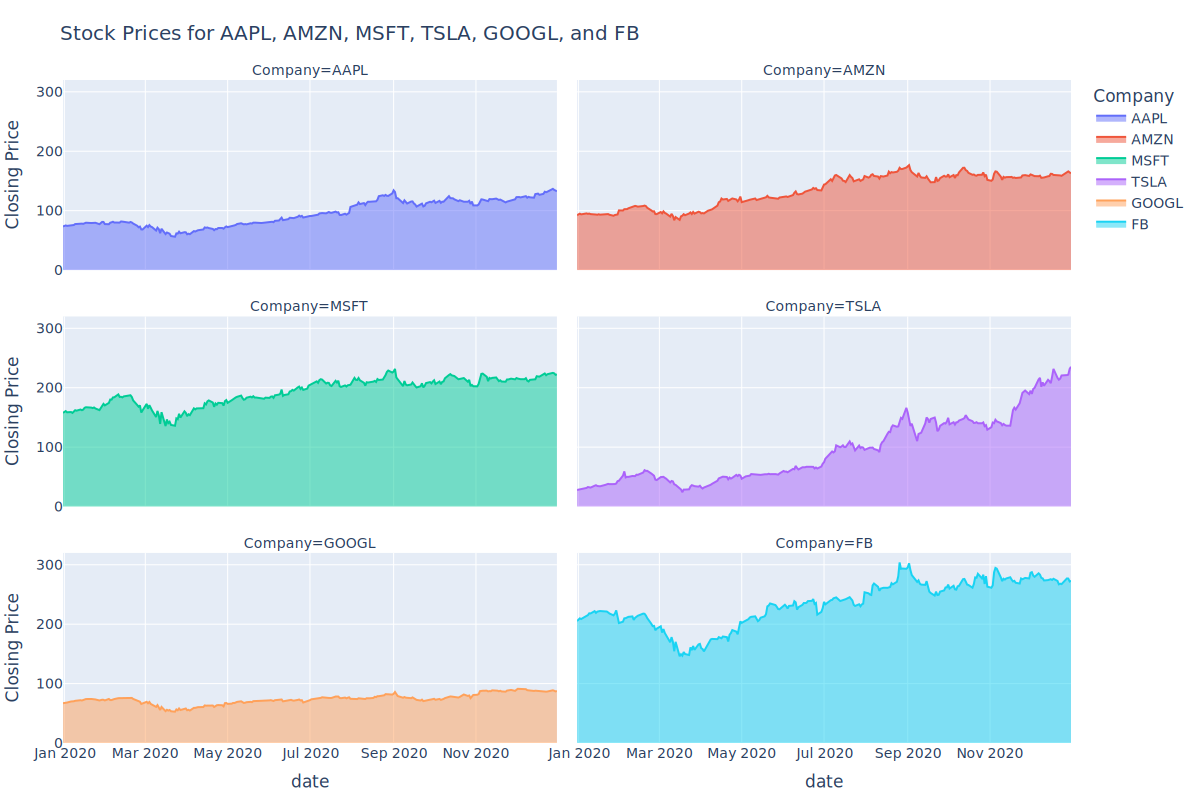

In [32]:
# Combine stock data into a single DataFrame
df_list = []
for ticker, data in stock_pandas_df.items():
    data["Ticker"] = ticker  # Add ticker column
    df_list.append(data)

df = pd.concat(df_list)  # Merge all stock DataFrames

# Ensure date is in datetime format
df['date'] = pd.to_datetime(df['date'])

# Plot area chart with facet column
fig = px.area(df, x='date', y='Close', color='Ticker',
              facet_col='Ticker', facet_col_wrap=2,  # Arrange in a 2x2 grid
              labels={'Date': 'Date', 'Close': 'Closing Price', 'Ticker': 'Company'},
              title='Stock Prices for AAPL, AMZN, MSFT, TSLA, GOOGL, and FB')

fig.update_layout(
    width=1200,
    height=800,
    title_font_size=20,
    font_size=14,
    margin=dict(l=50, r=50, t=80, b=50),
    showlegend=True
)

fig.show('svg')

**Stock Performance (Jan-Nov 2020):**  
- **COVID Impact**: All stocks dipped sharply in March 2020 (potentially Covid crash) but recovered strongly  
- **Top Performers**:  
  - TSLA: Most dramatic growth (~ **\$50** to ~ **\$235**) with high volatility  
  - AMZN: Maintained highest absolute price levels  
- **Steady Growth**: AAPL and MSFT showed consistent upward trajectories  
- **Moderate Movers**:  
  - FB: Notable fluctuations but less volatile than TSLA  
  - GOOGL: Very stable with minimal price swings  
- **Sector Resilience**: Tech stocks rebounded post-crash, peaking late 2020  

#### **Tweet WordCloud**

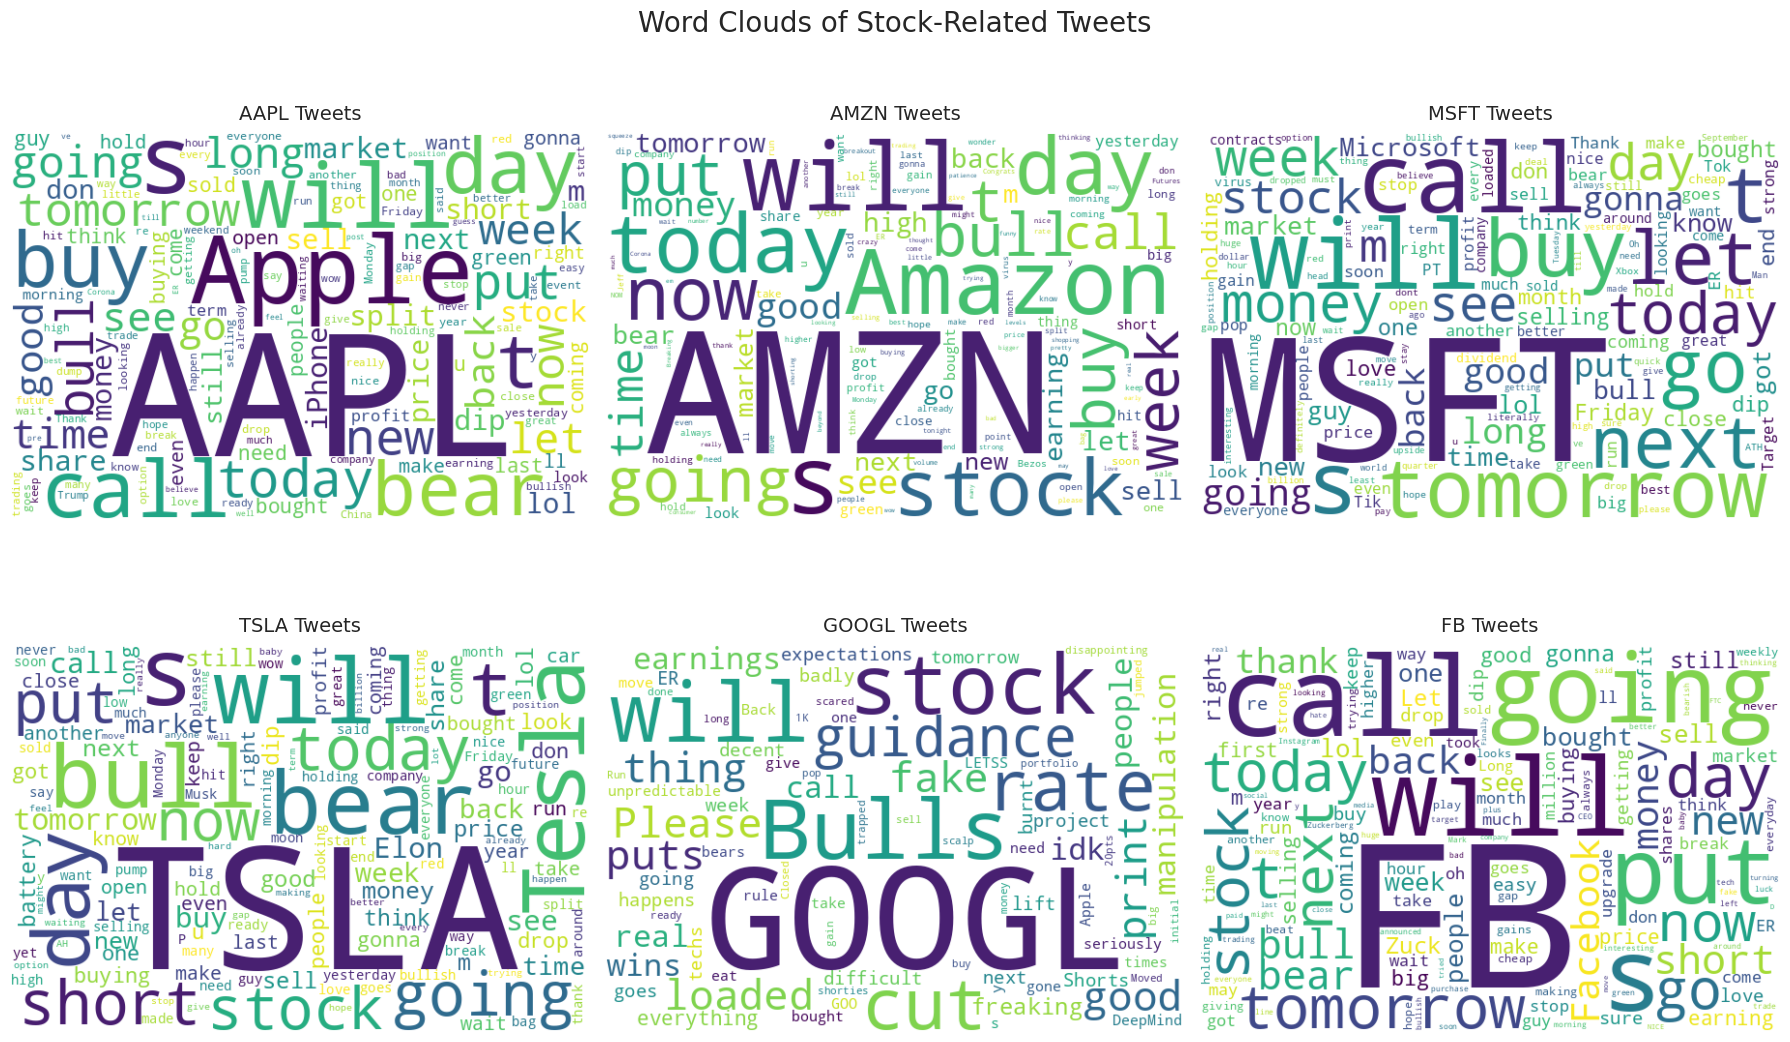

In [33]:
tickers = ['AAPL', 'AMZN', 'MSFT', 'TSLA', 'GOOGL', 'FB']

# Create a 2x3 grid (perfect for 6 tickers)
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Word Clouds of Stock-Related Tweets', fontsize=20, y=0.96)

# Flatten the axes array for easy iteration
axes = axes.flatten()

for i, ticker in enumerate(tickers):
    # Filter tweets for the current ticker and combine text
    text = ' '.join(tweets_pandas_df[tweets_pandas_df['ticker'] == ticker]['tweet'])
    
    # Generate word cloud with improved settings
    wordcloud = WordCloud(width=600, 
                         height=400,
                         background_color='white',
                         collocations=False,  # Don't show word pairs
                         random_state=42,
                         max_words=150).generate(text)
    
    # Plot in the appropriate subplot
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].set_title(f'{ticker} Tweets', fontsize=14, pad=10)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

The word clouds reveal common themes and sentiments associated with each stock ticker. For all companies, words like "buy," "sell," "call," "put," "today," "stock," and "going" dominate, reflecting active trading discussions and market sentiment. Company-specific terms also appear prominently, such as "Apple" and "iPhone" for AAPL, "Amazon" for AMZN, and "Elon" or "Musk" for TSLA, indicating strong brand associations in user discussions. The presence of words like "bull," "bear," "dip," "tomorrow," and "earnings" highlights common retail investor lingo and short-term trading focus. These insights suggest that social media sentiment around these tickers often revolves around speculation, earnings expectations, and general market movements.

<h3 style="background-color:#2D3436;color:white;border-radius:8px;padding:15px">Sentiment Analysis</h3>